In [1]:
import os
esmfmk = os.environ["ESMFMKFILE"] = 'C:/Users/x12la/anaconda3/envs/xe_env/Library/lib/esmf.mk'
print(esmfmk)
# or maybe need to put this into anaconda terminal 
# then reactivate the enviroment so that the variable is set 
#conda env config vars set $ESMFMKFILE=C:\Users\x12la\anaconda3\envs\xe_env\Library\lib\esmf.mk

import xarray as xr
import os
import xesmf as xe
#import ESMF
import pyproj
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import pandas as pd
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import geopandas as gpd
from netCDF4 import Dataset
from shapely.geometry import Point, shape, Polygon, mapping, box
from shapely.ops import unary_union, cascaded_union

C:/Users/x12la/anaconda3/envs/xe_env/Library/lib/esmf.mk


C:\Users\x12la\AppData\Local\Temp\ipykernel_19052\128725377.py:21: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# Load in LADCO grid 
grid=('C:/Users/x12la/Desktop/latlon_ChicagoLADCO_d03.nc')
cmaq_lon,cmaq_lat=np.array(Dataset(grid)['lon']),np.array(Dataset(grid)['lat'])
llat,ulat,llon,ulon=cmaq_lat.min(), cmaq_lat.max(), cmaq_lon.min(), cmaq_lon.max()

# Load emission datasets 
# Annual FIVE emissions at 4x4 km resolution over CONUS, units are in metric tons/km^2/hour 
five = xr.open_dataset('FIVE_WeightedAvg2018.nc')

# UVM dataset has been aggregated to 1.3x1.3 km resolution over Illinois for this analysis 
# Units are in Short Tons/Year
rowan = gpd.read_file('IL_1_33_wUVMEmis.shp')
rowan = rowan.to_crs('EPSG:4326')

# Nemo dataset is available at 1x1km across CONUSS, units are in metric tons/year (absolute emissions).
# NOX, PM25, PM10 have been calculated following speciations from EPA
nemo = xr.open_dataset('IL_onroad_201707_US01.nc')

# Four Month average (Jan,April,August,Oct) NU CCRG emission dataset - 1.3 x 1.3 km resolution over Midwest. 
# Units are in moles/second for each species molecular weight.
ladco = xr.open_dataset('C:/Users/x12la/Desktop/Scripts/onroad_annual_avg_MOVES3.nc') #datafile 
#Convert emissions to metric tons/hour following speciations found at https://www.epa.gov/system/files/documents/2022-07/420r22017.pdf
ladco['NOX_moles'] = ladco['NO'] + ladco['NO2'] # Calc nox [no2 + no] moles/s
ladco['NOX'] = ladco['NO']*(30.0061)*(3600)/(1e6) + ladco['NO2']*(46.005)*(3600)/(1e6) #METRIC TONS/Year
ladco['PM25'] = (ladco['PEC']+ladco['POC']+ladco['PNCOM']+ladco['PSO4']+ladco['PNO3']+ladco['PFE']+ladco['PAL']+ladco['PSI']+ladco['PTI']+ ladco['PCA']+ ladco['PMG']+ ladco['PK']+ ladco['PMN']+ ladco['PNA']+ladco['PCL']+ ladco['PMOTHR'])*(3600)/(1e6)  #grams/s converted to tons/hour
ladco['PM10'] = ladco['PM25'] + ladco['PMC']

In [3]:
# Chicago Met Planning Counties (Cook, DuPage, Kane, Kendall, Lake, McHenry, and Will ) https://www.cmap.illinois.gov/about
shpfile = '../CMAP_cty.shp'
cmap_cty = gpd.read_file(shpfile)
cmap_cty = cmap_cty.to_crs('EPSG: 4326')

In [4]:
# Adapted from https://kbkb-wx-python.blogspot.com/2016/08/find-nearest-latitude-and-longitude.html
def find_index(rowan_lon, rowan_lat, ladco_lon, ladco_lat):
# rowan lon/lat are individual points
# ladco lon/lat are 2D arrays 
    xx=[]; yy=[]
    for i in range(len(rowan_lon)):
        abslat = np.abs(ladco_lat - rowan_lat[i])
        abslon = np.abs(ladco_lon - rowan_lon[i])       
        c = np.maximum(abslon,abslat)
        latlon_idx = c.min
        x,y = np.where(c == np.min(c))
        xx.append(x) ; yy.append(y)
    return(xx,yy)

In [5]:
# Create 2D gridded data for Rowangould from the data's shapefile and LADCOs lat/lon grid 
# I do this because the shapefile cannot be directly converted into an xarray to compare with other datasets
rowan_nox = np.zeros((288, 315)) ; rowan_PM25 = np.zeros((288, 315)) ; rowan_PM10 = np.zeros((288, 315))

for ind in rowan.index:
    x, y = find_index([rowan['lon'][ind]], [rowan['lat'][ind]], cmaq_lon, cmaq_lat)
    rowan_nox[x,y] = rowan['All_NOx'][ind]
    rowan_PM25[x,y] = rowan['All_PM25'][ind]
    rowan_PM10[x,y] = rowan['All_PM10'][ind]

<h1> Make grids for each dataset 

In [6]:
def make_nemo_grid(domain_fn):
    '''
    Uses the following input data from NEMO file:
    e, n = (226999.75+500), (-387581.3799999999 +500) 
    dx_wrf, dy_wrf = 1000.0 , 1000.0 
    lat_1, lat_2, lat_0, lon_0 = 38.5, 38.5, 38.5, -97.5
    '''
    out_example = xr.open_dataset(domain_fn)
    #projection input from first line of surrogate file "GRID... ""
    wrf_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                    lat_1=38.5, lat_2=38.5, # Cone intersects with the sphere 33,45
                    lat_0=38.5, lon_0=-97.5, # Center point :MOAD_CEN_LAT = 39.34594f ; :STAND_LON = -97.f ;
                    a=6370000.0, b=6370000.0) # Radius
    # More info here: https://fabienmaussion.info/2018/01/06/wrf-projection/
    latlon_proj = pyproj.Proj(proj='latlong',ellps='WGS84',datum ='WGS84')

    # Grid parameters
    dx_wrf, dy_wrf = 1000.0 , 1000.0  #meters 
    nx_wrf, ny_wrf = out_example.dims['COL'], out_example.dims['ROW']
    e, n = (226999.75+500), (-387581.3799999999 +500)  # dataset provides corners of domain- but we want to use center points from the data so we add 500m
    # Down left corner of the domain
    x0_wrf ,y0_wrf = e,n

    # Grid of Grid Centers
    xx_wrf, yy_wrf = np.meshgrid(np.arange(nx_wrf) * dx_wrf + x0_wrf, np.arange(ny_wrf) * dy_wrf + y0_wrf)

    #Transformation of Center X-Y to Center Lat-Lon
    lon_wrf, lat_wrf = pyproj.transform(wrf_proj,latlon_proj,xx_wrf,yy_wrf)

    # Calculating the boundary X-Y Coordinates
    x_b_wrf, y_b_wrf = np.meshgrid(np.arange(nx_wrf+1) * dx_wrf + x0_wrf -dx_wrf/2, np.arange(ny_wrf+1) * dy_wrf + y0_wrf -dy_wrf/2)

#     out_example = out_example.assign_coords({
#         "lat": (["ROW", "COL"], lat_wrf),
#         "lon": (["ROW", "COL"], lon_wrf)
#     })                

    #Transformation of Boundary X-Y to Boundary Lat_Lon
    lon_b_wrf, lat_b_wrf = pyproj.transform(wrf_proj,latlon_proj,x_b_wrf,y_b_wrf)

    grid = {'lat': lat_wrf, #Center Point Spacing Lat
                    'lon': lon_wrf, #Center Point Spacing Lon
                    'lat_b': lat_b_wrf, # Boundary Spacing Lat
                    'lon_b': lon_b_wrf, # Boundary Spacing Lon
                    }

                    
    return grid

In [7]:
def make_nemo_corners(domain_fn):
    '''
    Uses the following input data from NEMO file:
    e, n = (226999.75+500), (-387581.3799999999 +500) 
    dx_wrf, dy_wrf = 1000.0 , 1000.0 
    lat_1, lat_2, lat_0, lon_0 = 38.5, 38.5, 38.5, -97.5
    '''
    
    out_example = xr.open_dataset(domain_fn)
    #projection input from first line of surrogate file "GRID... ""
    wrf_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                    lat_1=38.5, lat_2=38.5, # Cone intersects with the sphere 33,45
                    lat_0=38.5, lon_0=-97.5, # Center point :MOAD_CEN_LAT = 39.34594f ; :STAND_LON = -97.f ;
                    a=6370000.0, b=6370000.0) # Radius
    # More info here: https://fabienmaussion.info/2018/01/06/wrf-projection/
    latlon_proj = pyproj.Proj(proj='latlong',ellps='WGS84',datum ='WGS84')

    # Grid parameters
    dx_wrf, dy_wrf = 1000.0 , 1000.0  #meters 
    nx_wrf, ny_wrf = out_example.dims['COL']+1, out_example.dims['ROW']+1
    e, n = (226999.75), (-387581.3799999999)  # e/n bottom left hand corner
    # Down left corner of the domain
    x0_wrf ,y0_wrf = e,n
    
    # Grid of Grid Centers
    xx_wrf, yy_wrf = np.meshgrid(np.arange(nx_wrf) * dx_wrf + x0_wrf, np.arange(ny_wrf) * dy_wrf + y0_wrf)
    
    #Transformation of Center X-Y to Center Lat-Lon
    lon_wrf, lat_wrf = pyproj.transform(wrf_proj,latlon_proj,xx_wrf,yy_wrf)

    # Calculating the boundary X-Y Coordinates
    x_b_wrf, y_b_wrf = np.meshgrid(np.arange(nx_wrf+1) * dx_wrf + x0_wrf -dx_wrf/2, np.arange(ny_wrf+1) * dy_wrf + y0_wrf -dy_wrf/2)

    #Transformation of Boundary X-Y to Boundary Lat_Lon
    lon_b_wrf, lat_b_wrf = pyproj.transform(wrf_proj,latlon_proj,x_b_wrf,y_b_wrf)

    grid = {'lat': lat_wrf, #Center Point Spacing Lat
                    'lon': lon_wrf, #Center Point Spacing Lon
                    'lat_b': lat_b_wrf, # Boundary Spacing Lat
                    'lon_b': lon_b_wrf, # Boundary Spacing Lon
                    }
                    
    return grid

In [8]:
def make_FIVE_grid(domain_example_fn):
    out_example = xr.open_dataset(domain_example_fn, chunks={'Time': 1})
    
    out_example = out_example.rename({'south_north':'y'})
    out_example = out_example.rename({'west_east':'x'})
    out_example = out_example.rename({'XLAT': 'lat'})
    out_example = out_example.rename({'XLONG': 'lon'})
    out_example = out_example.set_coords(names=('lat','lon'))
        
    wrf_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                    lat_1=out_example.TRUELAT1, lat_2=out_example.TRUELAT2, # Cone intersects with the sphere 33,45
                    lat_0=out_example.MOAD_CEN_LAT, lon_0=out_example.STAND_LON, # Center point :MOAD_CEN_LAT = 39.34594f ; :STAND_LON = -97.f ;
                    a=6370000, b=6370000) # Radius
    # More info here: https://fabienmaussion.info/2018/01/06/wrf-projection/
    latlon_proj = pyproj.Proj(proj='latlong',ellps='WGS84',datum ='WGS84')
    
    # Construct Grid for WRF
    e, n = pyproj.transform(latlon_proj,wrf_proj,out_example.CEN_LON, out_example.CEN_LAT) #lower left hand corner of grid

    # Grid parameters
    dx_wrf, dy_wrf = out_example.DX, out_example.DY
    nx_wrf, ny_wrf = out_example.dims['x'], out_example.dims['y']
    
    # Down left corner of the domain
    x0_wrf = -(nx_wrf-1) / 2. * dx_wrf + e
    y0_wrf = -(ny_wrf-1) / 2. * dy_wrf + n

    # Grid of Grid Centers
    xx_wrf, yy_wrf = np.meshgrid(np.arange(nx_wrf) * dx_wrf + x0_wrf, np.arange(ny_wrf) * dy_wrf + y0_wrf)
    #Transformation of Center X-Y to Center Lat-Lon
    lon_wrf, lat_wrf = pyproj.transform(wrf_proj,latlon_proj,xx_wrf,yy_wrf)

    # Calculating the boundary X-Y Coordinates
    x_b_wrf, y_b_wrf = np.meshgrid(np.arange(nx_wrf+1) * dx_wrf + x0_wrf -dx_wrf/2, np.arange(ny_wrf+1) * dy_wrf + y0_wrf -dy_wrf/2)
    #Transformation of Boundary X-Y to Boundary Lat_Lon
    lon_b_wrf, lat_b_wrf = pyproj.transform(wrf_proj,latlon_proj,x_b_wrf,y_b_wrf)
    
    grid = {'lat': lat_wrf, #Center Point Spacing Lat
                    'lon': lon_wrf, #Center Point Spacing Lon
                    'lat_b': lat_b_wrf, # Boundary Spacing Lat
                    'lon_b': lon_b_wrf, # Boundary Spacing Lon
                    }
                    
    return grid

In [9]:
def make_FIVE_corners(domain_example_fn):
    out_example = xr.open_dataset(domain_example_fn, chunks={'Time': 1})
    out_example = out_example.rename({'south_north':'y'})
    out_example = out_example.rename({'west_east':'x'})
    out_example = out_example.rename({'XLAT': 'lat'})
    out_example = out_example.rename({'XLONG': 'lon'})
    out_example = out_example.set_coords(names=('lat','lon'))
        
    wrf_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                    lat_1=out_example.TRUELAT1, lat_2=out_example.TRUELAT2, # Cone intersects with the sphere 33,45
                    lat_0=out_example.MOAD_CEN_LAT, lon_0=out_example.STAND_LON, # Center point :MOAD_CEN_LAT = 39.34594f ; :STAND_LON = -97.f ;
                    a=6370000, b=6370000) # Radius
    # More info here: https://fabienmaussion.info/2018/01/06/wrf-projection/
    latlon_proj = pyproj.Proj(proj='latlong',ellps='WGS84',datum ='WGS84')
    
    # Construct Grid for WRF
    e, n = pyproj.transform(latlon_proj,wrf_proj,out_example.CEN_LON, out_example.CEN_LAT) #lower left hand corner of grid

    # Grid parameters
    dx_wrf, dy_wrf = out_example.DX, out_example.DY
    nx_wrf, ny_wrf = out_example.dims['x']+1, out_example.dims['y']+1
    # Down left corner of the domain
    x0_wrf = -(nx_wrf-1) / 2. * dx_wrf + e
    y0_wrf = -(ny_wrf-1) / 2. * dy_wrf + n

    # Grid of Grid Centers
    xx_wrf, yy_wrf = np.meshgrid(np.arange(nx_wrf) * dx_wrf + x0_wrf, np.arange(ny_wrf) * dy_wrf + y0_wrf)
    #Transformation of Center X-Y to Center Lat-Lon
    lon_wrf, lat_wrf = pyproj.transform(wrf_proj,latlon_proj,xx_wrf,yy_wrf)

    # Calculating the boundary X-Y Coordinates
    x_b_wrf, y_b_wrf = np.meshgrid(np.arange(nx_wrf+1) * dx_wrf + x0_wrf -dx_wrf/2, np.arange(ny_wrf+1) * dy_wrf + y0_wrf -dy_wrf/2)
    #Transformation of Boundary X-Y to Boundary Lat_Lon
    lon_b_wrf, lat_b_wrf = pyproj.transform(wrf_proj,latlon_proj,x_b_wrf,y_b_wrf)
    
    grid = {'lat': lat_wrf, #Center Point Spacing Lat
                    'lon': lon_wrf, #Center Point Spacing Lon
                    'lat_b': lat_b_wrf, # Boundary Spacing Lat
                    'lon_b': lon_b_wrf, # Boundary Spacing Lon
                    }
                    
    return grid

In [10]:
def make_ladco_grid(domain_fn):
    out_example = xr.open_dataset(domain_fn)
    
    out_example = out_example.rename({'COL':'x'})
    out_example = out_example.rename({'ROW':'y'})
    out_example = out_example.set_coords(names=('lat','lon'))
    
    wrf_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                    lat_1=33., lat_2=45., # Cone intersects with the sphere 33,45
                    lat_0=40., lon_0=-97., # Center point :MOAD_CEN_LAT = 39.34594f ; :STAND_LON = -97.f ;
                    a=6370000.0, b=6370000.0) # Radius
    # More info here: https://fabienmaussion.info/2018/01/06/wrf-projection/
    latlon_proj = pyproj.Proj(proj='latlong',ellps='WGS84',datum ='WGS84')

    # Construct Grid for WRF
    #e, n = pyproj.transform(latlon_proj,wrf_proj,-97, 40)
    #print(e,n)
    lonO, latO = wrf_proj(580000, 88000, inverse=True) # x origin, y origin 
    lonE, latE = wrf_proj((580000 + (1333.333 * 315)),(88000 + (1333.333 * 288)), inverse=True) #upper right 
    
    # Grid parameters
    dx_wrf, dy_wrf = 1333.333 , 1333.333  #meters 
    nx_wrf, ny_wrf = out_example.dims['x'], out_example.dims['y']
    
    # Down left corner of the domain
    #x0_wrf = -(nx_wrf-1) / 2. * dx_wrf + e
    #y0_wrf = -(ny_wrf-1) / 2. * dy_wrf + n
    x0_wrf ,y0_wrf  = (580000.0 + dx_wrf/2), (88000.0 + dy_wrf/2)
    
    #print(x0_wrf ,y0_wrf)
    
    # Grid of Grid Centers
    xx_wrf, yy_wrf = np.meshgrid(np.arange(nx_wrf) * dx_wrf + x0_wrf, np.arange(ny_wrf) * dy_wrf + y0_wrf)
    
    #Transformation of Center X-Y to Center Lat-Lon
    lon_wrf, lat_wrf = pyproj.transform(wrf_proj,latlon_proj,xx_wrf,yy_wrf)

    # Calculating the boundary X-Y Coordinates
    x_b_wrf, y_b_wrf = np.meshgrid(np.arange(nx_wrf+1) * dx_wrf + x0_wrf -dx_wrf/2, np.arange(ny_wrf+1) * dy_wrf + y0_wrf -dy_wrf/2)
    #Transformation of Boundary X-Y to Boundary Lat_Lon
    lon_b_wrf, lat_b_wrf = pyproj.transform(wrf_proj,latlon_proj,x_b_wrf,y_b_wrf)
    
    grid = {'lat': lat_wrf, #Center Point Spacing Lat
                    'lon': lon_wrf, #Center Point Spacing Lon
                    'lat_b': lat_b_wrf, # Boundary Spacing Lat
                    'lon_b': lon_b_wrf, # Boundary Spacing Lon
                    }
                    
    return grid

In [11]:
def make_ladco_corners(domain_fn):
    out_example = xr.open_dataset(domain_fn)
    
    out_example = out_example.rename({'COL':'x'})
    out_example = out_example.rename({'ROW':'y'})
    out_example = out_example.set_coords(names=('lat','lon'))
    
    wrf_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                    lat_1=33., lat_2=45., # Cone intersects with the sphere 33,45
                    lat_0=40., lon_0=-97., # Center point :MOAD_CEN_LAT = 39.34594f ; :STAND_LON = -97.f ;
                    a=6370000.0, b=6370000.0) # Radius
    # More info here: https://fabienmaussion.info/2018/01/06/wrf-projection/
    latlon_proj = pyproj.Proj(proj='latlong',ellps='WGS84',datum ='WGS84')

    # Construct Grid for WRF
    #e, n = pyproj.transform(latlon_proj,wrf_proj,-97, 40)
    #print(e,n)
    lonO, latO = wrf_proj(580000, 88000, inverse=True) # x origin, y origin 
    lonE, latE = wrf_proj((580000 + (1333.333 * 315)),(88000 + (1333.333 * 288)), inverse=True) #upper right 
    
    # Grid parameters
    dx_wrf, dy_wrf = 1333.333 , 1333.333  #meters 
    nx_wrf, ny_wrf = out_example.dims['x'], out_example.dims['y']
    
    # Down left corner of the domain
    #x0_wrf = -(nx_wrf-1) / 2. * dx_wrf + e
    #y0_wrf = -(ny_wrf-1) / 2. * dy_wrf + n
    x0_wrf ,y0_wrf  = (580000.0), (88000.0)
    
    #print(x0_wrf ,y0_wrf)
    
    # Grid of Grid Centers
    xx_wrf, yy_wrf = np.meshgrid(np.arange(nx_wrf) * dx_wrf + x0_wrf, np.arange(ny_wrf) * dy_wrf + y0_wrf)
    
    #Transformation of Center X-Y to Center Lat-Lon
    lon_wrf, lat_wrf = pyproj.transform(wrf_proj,latlon_proj,xx_wrf,yy_wrf)

    # Calculating the boundary X-Y Coordinates
    x_b_wrf, y_b_wrf = np.meshgrid(np.arange(nx_wrf+1) * dx_wrf + x0_wrf -dx_wrf/2, np.arange(ny_wrf+1) * dy_wrf + y0_wrf -dy_wrf/2)
    #Transformation of Boundary X-Y to Boundary Lat_Lon
    lon_b_wrf, lat_b_wrf = pyproj.transform(wrf_proj,latlon_proj,x_b_wrf,y_b_wrf)
    
    grid = {'lat': lat_wrf, #Center Point Spacing Lat
                    'lon': lon_wrf, #Center Point Spacing Lon
                    'lat_b': lat_b_wrf, # Boundary Spacing Lat
                    'lon_b': lon_b_wrf, # Boundary Spacing Lon
                    }
                    
    return grid

In [12]:
# Call above functions to generate gridded files 
nemo_grid = make_nemo_grid('IL_onroad_201707_US01.nc')
nemo_corners = make_nemo_corners('IL_onroad_201707_US01.nc')
five_grid = make_FIVE_grid('FIVE_WeightedAvg2018.nc')
five_corners = make_FIVE_corners('FIVE_WeightedAvg2018.nc')
ladco_grid = make_ladco_grid('C:/Users/x12la/Desktop/latlon_ChicagoLADCO_d03.nc')
ladco_corners =  make_ladco_corners('C:/Users/x12la/Desktop/latlon_ChicagoLADCO_d03.nc')
rowan_grid = make_ladco_grid('C:/Users/x12la/Desktop/latlon_ChicagoLADCO_d03.nc')

C:\Users\x12la\AppData\Local\Temp\ipykernel_19052\1322363663.py:28: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_wrf, lat_wrf = pyproj.transform(wrf_proj,latlon_proj,xx_wrf,yy_wrf)
C:\Users\x12la\AppData\Local\Temp\ipykernel_19052\1322363663.py:39: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_b_wrf, lat_b_wrf = pyproj.transform(wrf_proj,latlon_proj,x_b_wrf,y_b_wrf)
C:\Users\x12la\AppData\Local\Temp\ipykernel_19052\2271484026.py:29: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_wrf, lat_wrf = pyproj.transform(wrf_proj,latlon_proj,xx_wrf,yy_wrf)
C:\Users\x12la\AppData\Local\Temp\ipykernel_19052\2271484026.py:35: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stab

In [14]:
# regridding for 1_33km grids
# before interpolating 
# NEMO data is provided in metric tons/km2/year  
# Multiply regridded data by 1.33 km**2 to convert flux into absolute emissions
regridder = xe.Regridder(nemo_grid, ladco_grid, 'conservative',reuse_weights=False)
nemo_nox_1_33km = (regridder(nemo.NOXANN[0][0]))*(1.33**2)
nemo_pm25_1_33km = (regridder(nemo.PM25ANN[0][0]))*(1.33**2)
nemo_pm10_1_33km = (regridder(nemo.PM25ANN[0][0]+nemo.PMCANN[0][0]))*(1.33**2)

# Regrid uvm to 1.33km 
# Originally in short tons/year 
# Convert short tons to metric tons, convert absolute emissions to emission flux by dividing grid area
# Convert regridded emission flux to abs emissions by multiplying emissions by gridded area
regridder = xe.Regridder(rowan_grid, ladco_grid, 'conservative',reuse_weights=False)
rowan_nox_1_33km = (regridder((rowan_nox*907185/(1e6*1.33**2))))*(1.33**2)
rowan_pm25_1_33km = (regridder((rowan_PM25*907185/(1e6*1.33**2))))*(1.33**2)  
rowan_pm10_1_33km = (regridder((rowan_PM10*907185/(1e6*1.33**2))))*(1.33**2)

#LADCO 
# Data is in metric tons/hour, convert data to emission flux of metric tons/km2/year
# Convert regridded emission flux to abs emissions by multiplying emissions by gridded area
regridder = xe.Regridder(ladco_grid, ladco_grid, 'conservative',reuse_weights=False)
ladco_nox_1_33km = (regridder((ladco['NOX'][0][0]*(8760)/(1.33**2))))*(1.33**2)
ladco_pm25_1_33km = (regridder(ladco['PM25'][0][0]*(8760)/(1.33**2)))*(1.33**2)
ladco_pm10_1_33km = (regridder(ladco['PM10'][0][0]*(8760)/(1.33**2)))*(1.33**2)

#FIVE 1_33km to 1_33km 
# convert Tons/km2/hour to tons/km2/year
# Convert regridded emission flux to abs emissions by multiplying emissions by gridded area
regridder = xe.Regridder(five_grid, ladco_grid, 'conservative', reuse_weights=False)
five_nox_1_33km = (regridder(five.All_NOX[0]*(8760)))*(1.33**2)
five_pm25_1_33km = (regridder(five.All_PM25[0]*(8760)))*(1.33**2)
five_pm10_1_33km = (regridder(five.All_PM10[0]*(8760)))*(1.33**2)

C:\Users\x12la\anaconda3\lib\site-packages\xesmf\frontend.py:595: UserWarning: Using dimensions ('south_north', 'west_east') from data variable All_NOX as the horizontal dimensions for the regridding.
  warnings.warn(
C:\Users\x12la\anaconda3\lib\site-packages\xesmf\frontend.py:595: UserWarning: Using dimensions ('south_north', 'west_east') from data variable All_PM25 as the horizontal dimensions for the regridding.
  warnings.warn(
C:\Users\x12la\anaconda3\lib\site-packages\xesmf\frontend.py:595: UserWarning: Using dimensions ('south_north', 'west_east') from data variable All_PM10 as the horizontal dimensions for the regridding.
  warnings.warn(


<h1> Plot NOx emissions 

Sum:  <xarray.DataArray ()>
array(175678.94, dtype=float32)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(1.9364963, dtype=float32)
Max:  <xarray.DataArray ()>
array(76.69291687)


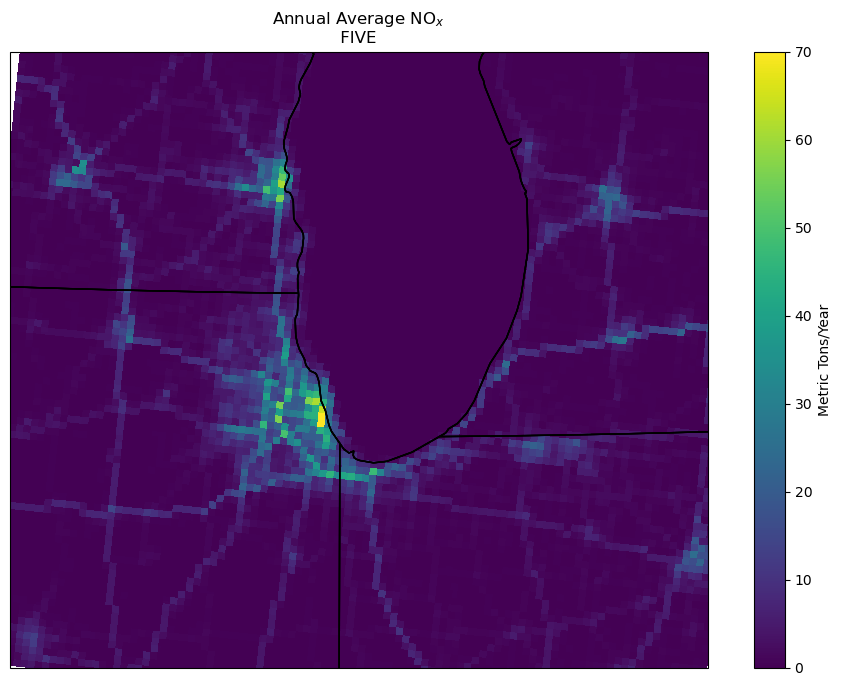

In [15]:
# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.viridis
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
#ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average NO$_x$\n FIVE ")
plt.pcolormesh(five_nox_1_33km['lon'], five_nox_1_33km['lat'], five_nox_1_33km, transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
plt.clim(0,70)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Metric Tons/Year")

# class1_roads= ShapelyFeature(Reader('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp').geometries(),
#                                 ccrs.PlateCarree(), facecolor='none')
# ax.add_feature(class1_roads, alpha=.25)
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', ( five_nox_1_33km.sum()))
print('Min: ', ( five_nox_1_33km.min()))
print('Mean: ', ( five_nox_1_33km.mean()))      
print('Max: ', ( five_nox_1_33km.max()))

Sum:  <xarray.DataArray ()>
array(175678.94, dtype=float32)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(1.9364963, dtype=float32)
Max:  <xarray.DataArray ()>
array(76.69291687)


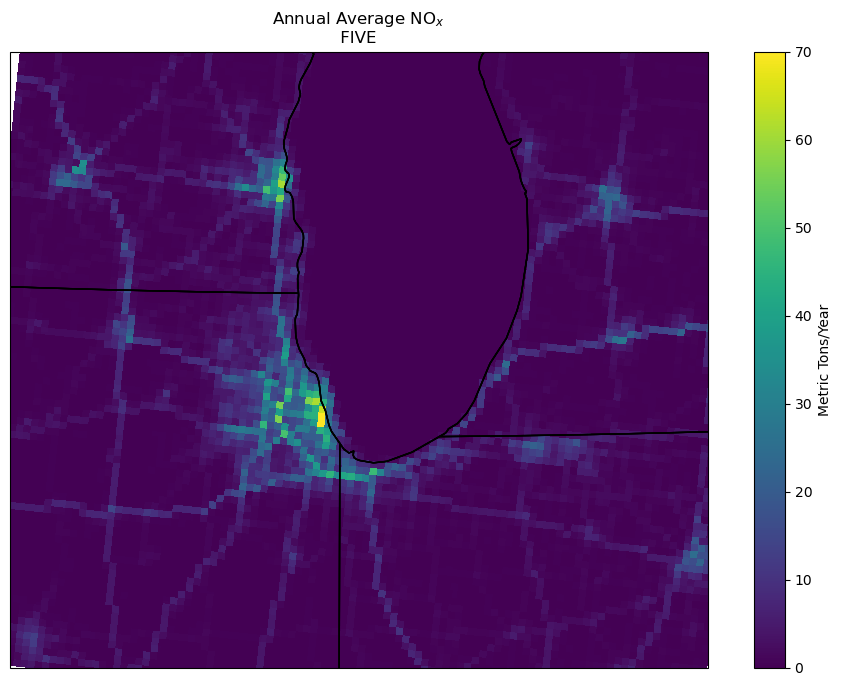

In [20]:
# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.viridis
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
#ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average NO$_x$\n FIVE ")
plt.pcolormesh(five_nox_1_33km['lon'], five_nox_1_33km['lat'], five_nox_1_33km, transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
plt.clim(0,70)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Metric Tons/Year")

# class1_roads= ShapelyFeature(Reader('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp').geometries(),
#                                 ccrs.PlateCarree(), facecolor='none')
# ax.add_feature(class1_roads, alpha=.25)
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', ( five_nox_1_33km.sum()))
print('Min: ', ( five_nox_1_33km.min()))
print('Mean: ', ( five_nox_1_33km.mean()))      
print('Max: ', ( five_nox_1_33km.max()))

Sum:  <xarray.DataArray ()>
array(175678.94, dtype=float32)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(1.9364963, dtype=float32)
Max:  <xarray.DataArray ()>
array(76.69291687)


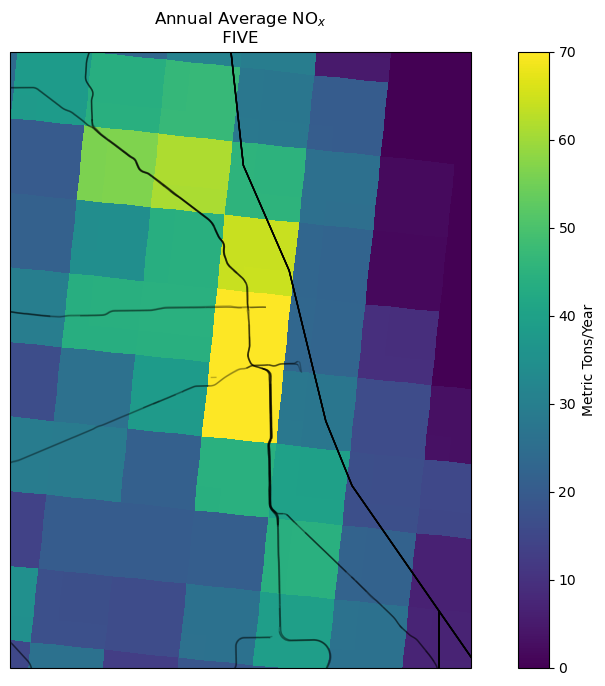

In [21]:
# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.viridis
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average NO$_x$\n FIVE ")
plt.pcolormesh(five_nox_1_33km['lon'], five_nox_1_33km['lat'], five_nox_1_33km, transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
plt.clim(0,70)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Metric Tons/Year")

class1_roads= ShapelyFeature(Reader('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='none')
ax.add_feature(class1_roads, alpha=.25)
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', ( five_nox_1_33km.sum()))
print('Min: ', ( five_nox_1_33km.min()))
print('Mean: ', ( five_nox_1_33km.mean()))      
print('Max: ', ( five_nox_1_33km.max()))

Sum:  <xarray.DataArray ()>
array(99960.78, dtype=float32)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(1.1018604, dtype=float32)
Max:  <xarray.DataArray ()>
array(138.54762268)


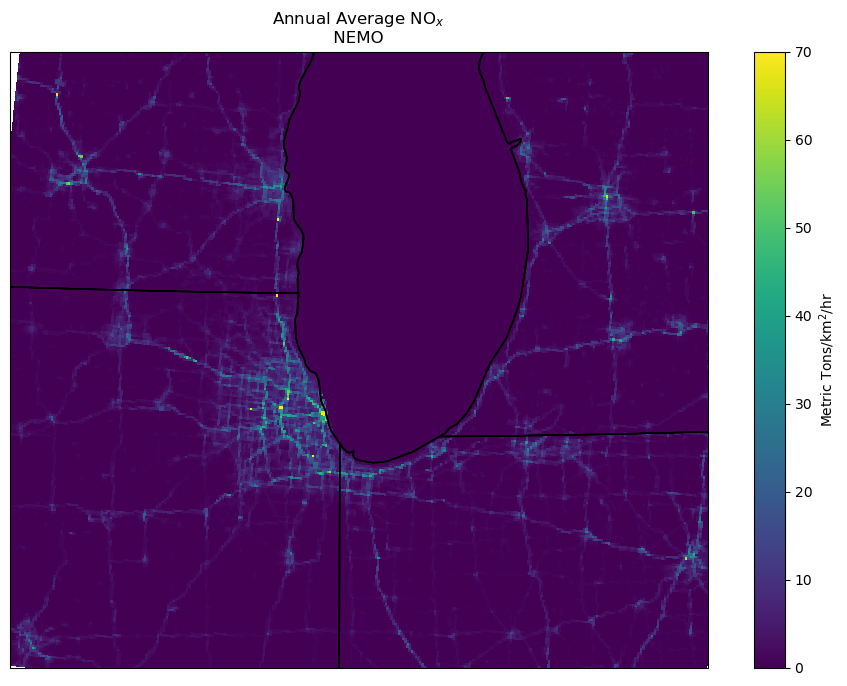

In [22]:
# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.viridis
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
#ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average NO$_x$ \n NEMO ")
plt.pcolormesh(nemo_nox_1_33km['lon'], nemo_nox_1_33km['lat'], nemo_nox_1_33km,transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
#plt.scatter(nemo_grid['lon'][1123,121], nemo_grid['lat'][1123,121], color='red')
plt.clim(0,70)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Metric Tons/km$^2$/hr")

# class1_roads= ShapelyFeature(Reader('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp').geometries(),
#                                 ccrs.PlateCarree(), facecolor='none')
# ax.add_feature(class1_roads, alpha=.25)
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', (nemo_nox_1_33km.sum()))
print('Min: ', (nemo_nox_1_33km.min()))
print('Mean: ', (nemo_nox_1_33km.mean()))      
print('Max: ', (nemo_nox_1_33km.max()))

Sum:  <xarray.DataArray ()>
array(99960.78, dtype=float32)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(1.1018604, dtype=float32)
Max:  <xarray.DataArray ()>
array(138.54762268)


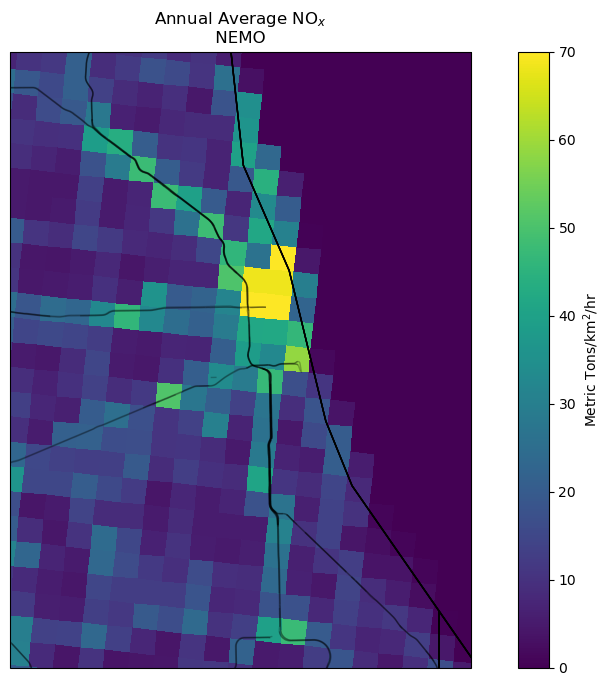

In [23]:
# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.viridis
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average NO$_x$ \n NEMO ")
plt.pcolormesh(nemo_nox_1_33km['lon'], nemo_nox_1_33km['lat'], nemo_nox_1_33km,transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
#plt.scatter(nemo_grid['lon'][1123,121], nemo_grid['lat'][1123,121], color='red')
plt.clim(0,70)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Metric Tons/km$^2$/hr")

class1_roads= ShapelyFeature(Reader('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='none')
ax.add_feature(class1_roads, alpha=.25)
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', (nemo_nox_1_33km.sum()))
print('Min: ', (nemo_nox_1_33km.min()))
print('Mean: ', (nemo_nox_1_33km.mean()))      
print('Max: ', (nemo_nox_1_33km.max()))

Sum:  <xarray.DataArray ()>
array(105161.48, dtype=float32)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(1.1591873, dtype=float32)
Max:  <xarray.DataArray ()>
array(241.0995636)


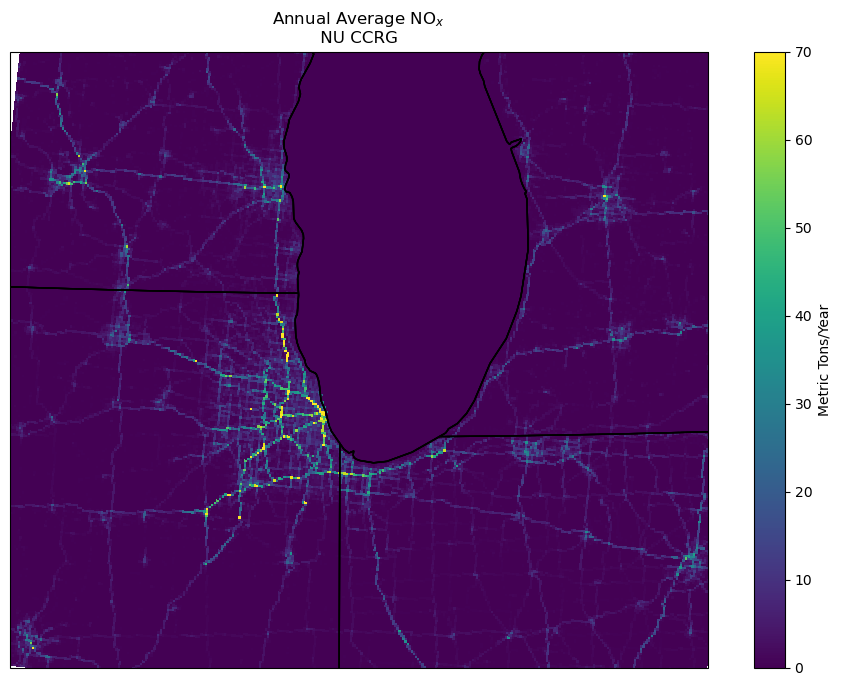

In [26]:
# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.viridis
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
#ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average NO$_x$ \n NU CCRG ")
plt.pcolormesh(ladco_nox_1_33km['lon'],ladco_nox_1_33km['lat'], ladco_nox_1_33km ,transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
#plt.scatter(cmaq_lon[119,142], cmaq_lat[119,142],color=)
plt.clim(0,70)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Metric Tons/Year")

# class1_roads= ShapelyFeature(Reader('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp').geometries(),
#                                 ccrs.PlateCarree(), facecolor='none')
# ax.add_feature(class1_roads, alpha=.25)
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', (ladco_nox_1_33km.sum()))
print('Min: ', (ladco_nox_1_33km.min()))
print('Mean: ', (ladco_nox_1_33km.mean()))      
print('Max: ', (ladco_nox_1_33km.max()))

Sum:  <xarray.DataArray ()>
array(105161.48, dtype=float32)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(1.1591873, dtype=float32)
Max:  <xarray.DataArray ()>
array(241.0995636)


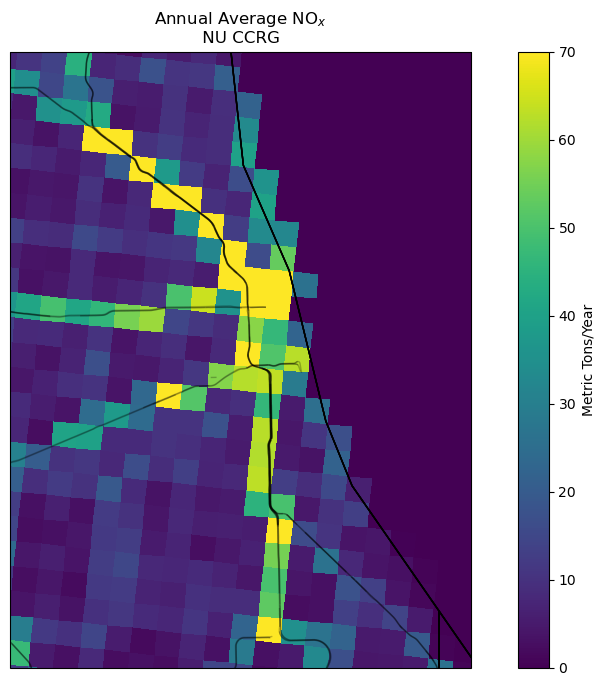

In [27]:
# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.viridis
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average NO$_x$ \n NU CCRG ")
plt.pcolormesh(ladco_nox_1_33km['lon'],ladco_nox_1_33km['lat'], ladco_nox_1_33km ,transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
#plt.scatter(cmaq_lon[119,142], cmaq_lat[119,142],color=)
plt.clim(0,70)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Metric Tons/Year")

class1_roads= ShapelyFeature(Reader('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='none')
ax.add_feature(class1_roads, alpha=.25)
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', (ladco_nox_1_33km.sum()))
print('Min: ', (ladco_nox_1_33km.min()))
print('Mean: ', (ladco_nox_1_33km.mean()))      
print('Max: ', (ladco_nox_1_33km.max()))

Sum:  <xarray.DataArray ()>
array(51765.82791205)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(0.57061098)
Max:  <xarray.DataArray ()>
array(104.37233804)


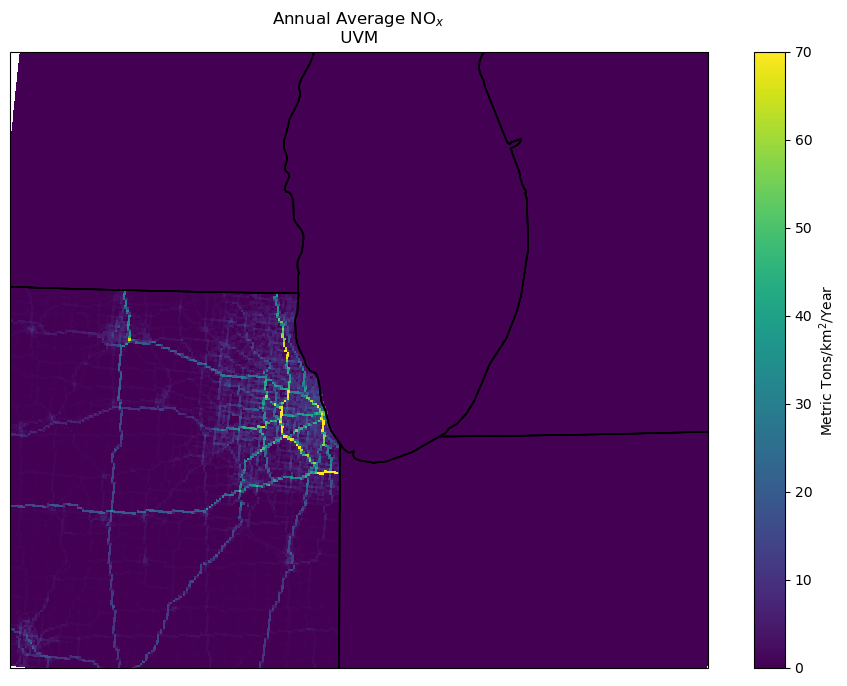

In [29]:
rowan_nox_1_33km = xr.DataArray(rowan_nox_1_33km,
                      coords= {'lat': five_nox_1_33km['lat'] , 'lon':five_nox_1_33km['lon']},
                      dims=['y','x'])

# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.viridis
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
#ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average NO$_x$ \n UVM ")
plt.pcolormesh(rowan_nox_1_33km['lon'], rowan_nox_1_33km['lat'], rowan_nox_1_33km ,transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
#plt.scatter(cmaq_lon[95,148], cmaq_lat[95,148],color='red')
plt.clim(0,70)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Metric Tons/km$^2$/Year")

# class1_roads= ShapelyFeature(Reader('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp').geometries(),
#                                 ccrs.PlateCarree(), facecolor='none')
# ax.add_feature(class1_roads, alpha=.25)
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', (rowan_nox_1_33km.sum()))
print('Min: ', (rowan_nox_1_33km.min()))
print('Mean: ', (rowan_nox_1_33km.mean()))      
print('Max: ', (rowan_nox_1_33km.max()))

Sum:  <xarray.DataArray ()>
array(51765.82791205)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(0.57061098)
Max:  <xarray.DataArray ()>
array(104.37233804)


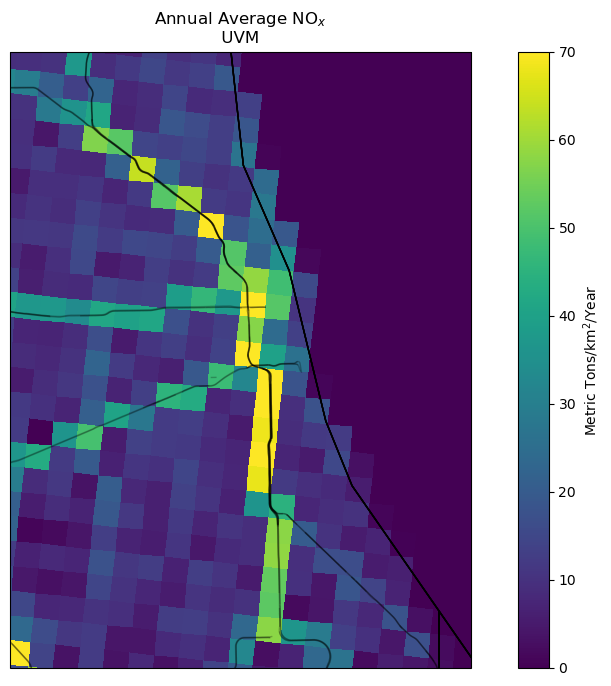

In [30]:
rowan_nox_1_33km = xr.DataArray(rowan_nox_1_33km,
                      coords= {'lat': five_nox_1_33km['lat'] , 'lon':five_nox_1_33km['lon']},
                      dims=['y','x'])

# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.viridis
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average NO$_x$ \n UVM ")
plt.pcolormesh(rowan_nox_1_33km['lon'], rowan_nox_1_33km['lat'], rowan_nox_1_33km ,transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
#plt.scatter(cmaq_lon[95,148], cmaq_lat[95,148],color='red')
plt.clim(0,70)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Metric Tons/km$^2$/Year")

class1_roads= ShapelyFeature(Reader('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='none')
ax.add_feature(class1_roads, alpha=.25)
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', (rowan_nox_1_33km.sum()))
print('Min: ', (rowan_nox_1_33km.min()))
print('Mean: ', (rowan_nox_1_33km.mean()))      
print('Max: ', (rowan_nox_1_33km.max()))

<h1> Plot PM2.5 Emissions

Sum:  <xarray.DataArray ()>
array(6160.2856, dtype=float32)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(0.06790438, dtype=float32)
Max:  <xarray.DataArray ()>
array(2.62078595)


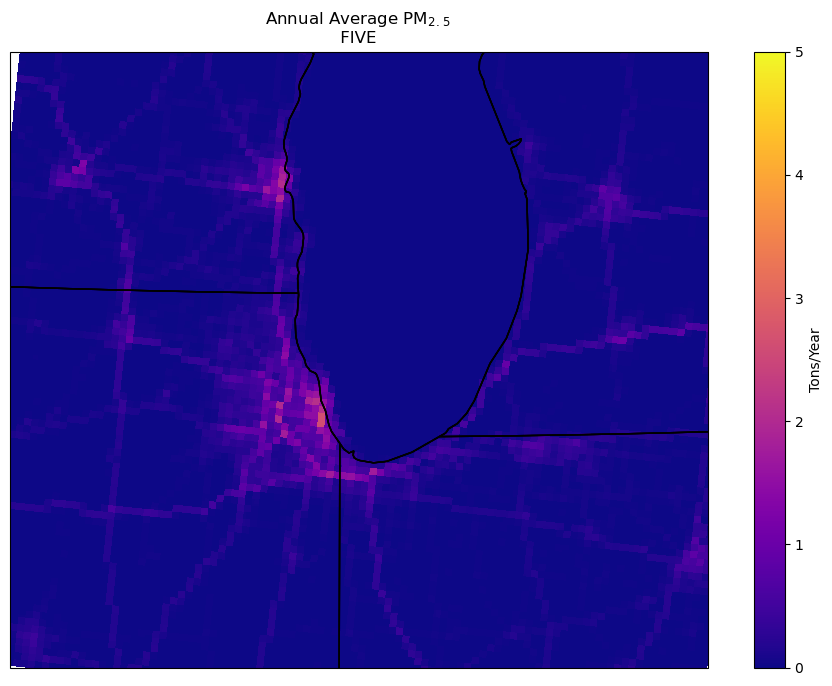

In [31]:
# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.plasma
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
#ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average PM$_2$$_.$$_5$ \n FIVE ")
plt.pcolormesh(five_pm25_1_33km['lon'], five_pm25_1_33km['lat'], five_pm25_1_33km ,transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
plt.clim(0,5)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Tons/Year")

# class1_roads= ShapelyFeature(Reader('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp').geometries(),
#                                 ccrs.PlateCarree(), facecolor='none')
# ax.add_feature(class1_roads, alpha=.25)
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', ( five_pm25_1_33km.sum()))
print('Min: ', ( five_pm25_1_33km.min()))
print('Mean: ', ( five_pm25_1_33km.mean()))      
print('Max: ', ( five_pm25_1_33km.max()))

Sum:  <xarray.DataArray ()>
array(5169.9644, dtype=float32)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(0.05698814, dtype=float32)
Max:  <xarray.DataArray ()>
array(6.27404213)


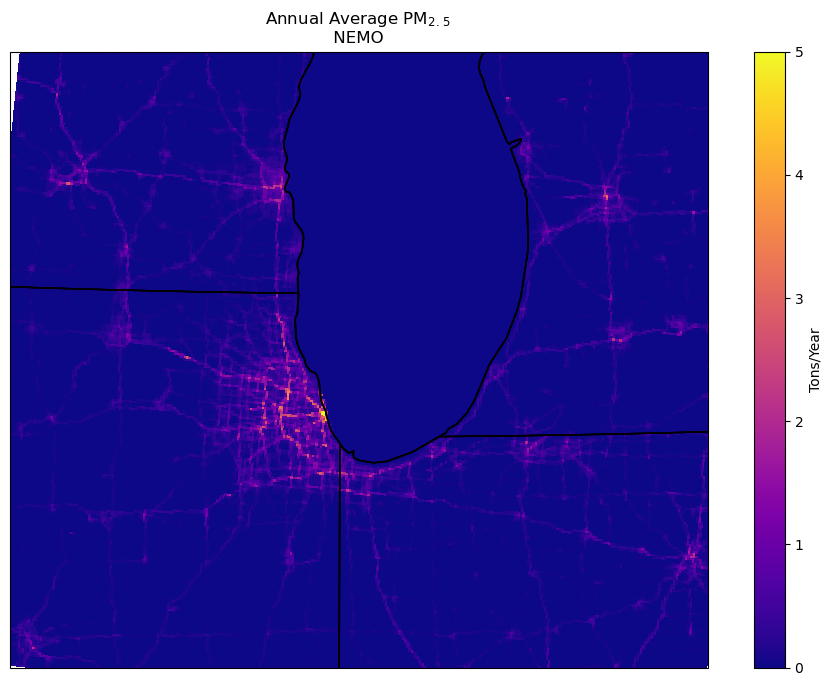

In [32]:
# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.plasma
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
#ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average PM$_2$$_.$$_5$ \n NEMO ")
plt.pcolormesh(nemo_pm25_1_33km['lon'], nemo_pm25_1_33km['lat'], nemo_pm25_1_33km,transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
plt.clim(0,5)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Tons/Year")
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', (nemo_pm25_1_33km.sum()))
print('Min: ', (nemo_pm25_1_33km.min()))
print('Mean: ', (nemo_pm25_1_33km.mean()))      
print('Max: ', (nemo_pm25_1_33km.max()))

Sum:  <xarray.DataArray ()>
array(4782.019, dtype=float32)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(0.05271185, dtype=float32)
Max:  <xarray.DataArray ()>
array(11.65383148)


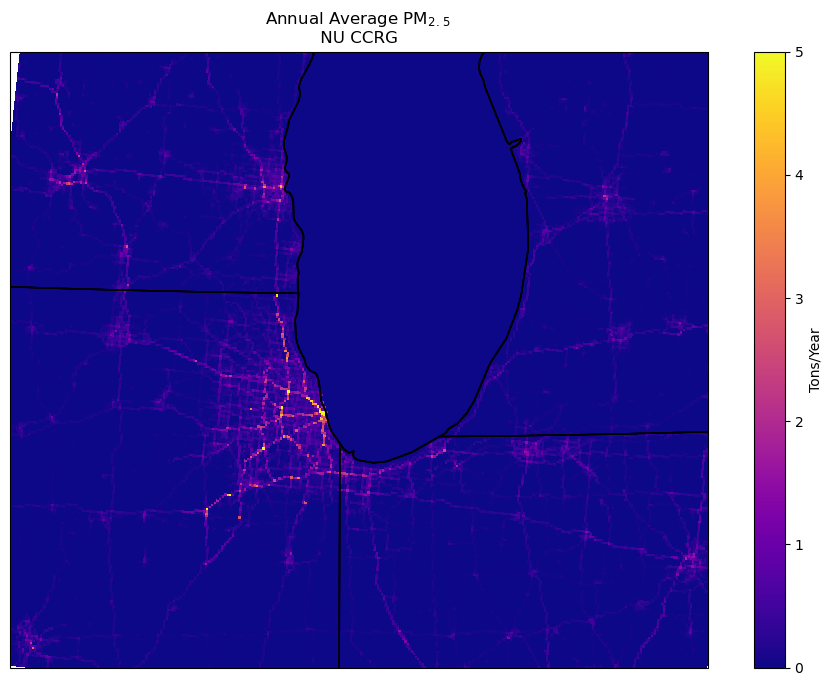

In [34]:
# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.plasma
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
#ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average PM$_2$$_.$$_5$ \n NU CCRG ")
plt.pcolormesh(ladco_pm25_1_33km['lon'],ladco_pm25_1_33km['lat'], ladco_pm25_1_33km ,transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
#plt.scatter(cmaq_lon[119,142], cmaq_lat[119,142],color=)
plt.clim(0,5)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Tons/Year")

# class1_roads= ShapelyFeature(Reader('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp').geometries(),
#                                 ccrs.PlateCarree(), facecolor='none')
# ax.add_feature(class1_roads, alpha=.25)
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', (ladco_pm25_1_33km.sum()))
print('Min: ', (ladco_pm25_1_33km.min()))
print('Mean: ', (ladco_pm25_1_33km.mean()))      
print('Max: ', (ladco_pm25_1_33km.max()))

Sum:  <xarray.DataArray ()>
array(1593.23194973)
Min:  <xarray.DataArray ()>
array(0.)
Mean:  <xarray.DataArray ()>
array(0.01756208)
Max:  <xarray.DataArray ()>
array(2.8517472)


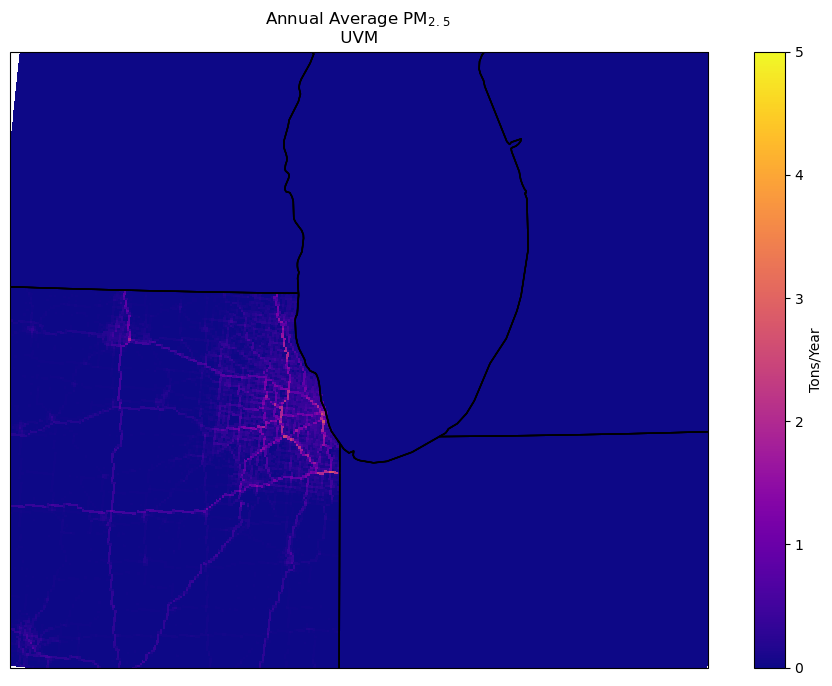

In [40]:
rowan_pm25_1_33km = xr.DataArray(rowan_pm25_1_33km,
                      coords= {'lat': ladco_pm25_1_33km['lat'] , 'lon':ladco_pm25_1_33km['lon']},
                      dims=['y','x'])

# plot figure
fig= plt.figure(figsize=(12,8))
cmap = plt.cm.plasma
rev_cmap = cmap

# set up axes to model domain (ChicagoLADCO_d03)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-87.62, central_latitude=41.88))
ax.set_extent([np.amin(cmaq_lon)+0.35,np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-0.35])
#ax.set_extent([-87.5, -87.8, 41.7, 42])
# plot variable 
plt.title("Annual Average PM$_2$$_.$$_5$ \n UVM ")
plt.pcolormesh(rowan_pm25_1_33km['lon'], rowan_pm25_1_33km['lat'], rowan_pm25_1_33km ,transform=ccrs.PlateCarree(),cmap=rev_cmap,vmin=0)
#plt.scatter(cmaq_lon[95,148], cmaq_lat[95,148],color='red')
plt.clim(0,5)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')
plt.colorbar(label="Tons/Year")

# class1_roads= ShapelyFeature(Reader('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp').geometries(),
#                                 ccrs.PlateCarree(), facecolor='none')
# ax.add_feature(class1_roads, alpha=.25)
      
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None')
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor='None')

print('Sum: ', (rowan_pm25_1_33km.sum()))
print('Min: ', (rowan_pm25_1_33km.min()))
print('Mean: ', (rowan_pm25_1_33km.mean()))      
print('Max: ', (rowan_pm25_1_33km.max()))

<h1> Create shapefiles for each dataset

In [43]:
# # gridded corners from 1.33 km grid -- doesn't matter dates
f = xr.open_dataset('GRIDDOT2D_Chicago_LADCO_2018-08-16.nc')
lond,latd = np.array(f['LOND'][0][0]),np.array(f['LATD'][0][0])

# # pull in lat lon data -- doesn't matter dates
d03 = xr.open_dataset('GRIDCRO2D_Chicago_LADCO_2018-08-16.nc')  
lat3,lon3 = np.array(d03['LAT'][0][0]),np.array(d03['LON'][0][0])
lat,lon = lat3,lon3

In [44]:
## FIVE 
five_nox_1_33km = xr.DataArray(five_nox_1_33km,
                      coords= {'lat':five_nox_1_33km['lat'] , 'lon':five_nox_1_33km['lon']},
                      dims=['y','x'])

datas = [np.array(five_nox_1_33km).ravel(),np.array(five_pm25_1_33km).ravel(),np.array(five_pm10_1_33km).ravel()]
datas_headers = ['NOX','PM25','PM10']

In [45]:
###
d = {}
for i in range(len(datas)):
    d[datas_headers[i]]=datas[i]

# pull locations and put into shapely point so we can do geographical transformations
pointline = [Point(lon.ravel()[i],lat.ravel()[i]) for i in range(len(lon.ravel()))]
# add in geometry into dictionary
d['geometry']=pointline

# make geodataframe using dictionary and transform lon/lats projections into the same geometry as the tracts
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
#gdf = gdf.to_crs(tract_shapes.crs)
# pull out these lat lon points that have the tract crs
x,y = gdf['geometry'].x,gdf['geometry'].y

# Start to make little polygons to surround the centroids
# Create outer limits
#       L
#       lu----ru
# H     |   c  |
#       |      |
#       ll----rl
#
# set up empty shape to hold the future polygons
shape=np.zeros(lon.shape).tolist()
# go through the indices in the lat lon
for i in range(len(lon)):
        for j in range(len(lon[0])):
            X0,Y0 = lat[i][j],lon[i][j]
            # get corners
            lo_lu, la_lu = latd[i][j],lond[i][j]
            lo_ru, la_ru = latd[i+1][j],lond[i+1][j]
            lo_rl, la_rl = latd[i+1][j+1],lond[i+1][j+1]
            lo_ll, la_ll = latd[i][j+1],lond[i][j+1]
            # create points of corners
            pointList = [Point(lo_lu, la_lu),Point(lo_ru, la_ru), Point(lo_rl, la_rl), Point(lo_ll, la_ll),Point(lo_lu, la_lu)]
            # create a polygon from the corners
            poly = Polygon([[p.y, p.x] for p in pointList])
            # put the shape of the pixel into the shape list
            shape[i][j] = poly 

In [46]:
# put list of shapes into final gdf, needs to be 1D
shape = np.array(shape).ravel()
d['geometry'] = shape
d['lat'],d['lon'] = lat.ravel(),lon.ravel()
d['lat_m'],d['lon_m'] = x,y
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
gdf.to_file('five_1_33km_cons_annual.shp')

In [47]:
cmap_five = gpd.clip(gdf, cmap_cty.to_crs('EPSG:4326'))

<Axes: >

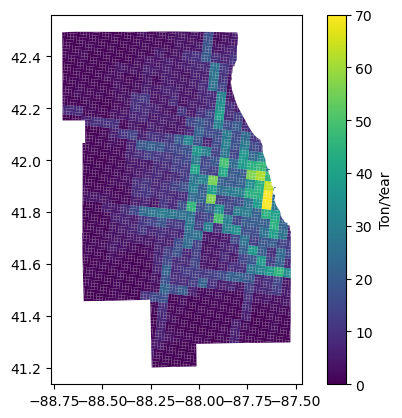

In [53]:
cmap_five.plot('NOX', vmin=0, vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"})#),antialiased=False)

In [54]:
## NEMO 
nemo_nox_1_33km = xr.DataArray(nemo_nox_1_33km,
                      coords= {'lat':nemo_nox_1_33km['lat'] , 'lon':nemo_nox_1_33km['lon']},
                      dims=['y','x'])

datas = [np.array(nemo_nox_1_33km).ravel(),np.array(nemo_pm25_1_33km).ravel(),np.array(nemo_pm10_1_33km).ravel()]
datas_headers = ['NOX','PM25','PM10']

In [55]:
###
d = {}
for i in range(len(datas)):
    d[datas_headers[i]]=datas[i]

# pull locations and put into shapely point so we can do geographical transformations
pointline = [Point(lon.ravel()[i],lat.ravel()[i]) for i in range(len(lon.ravel()))]
# add in geometry into dictionary
d['geometry']=pointline

# make geodataframe using dictionary and transform lon/lats projections into the same geometry as the tracts
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
#gdf = gdf.to_crs(tract_shapes.crs)
# pull out these lat lon points that have the tract crs
x,y = gdf['geometry'].x,gdf['geometry'].y

In [56]:
# Start to make little polygons to surround the centroids
# Create outer limits
#       L
#       lu----ru
# H     |   c  |
#       |      |
#       ll----rl
#
# set up empty shape to hold the future polygons
shape=np.zeros(lon.shape).tolist()
# go through the indices in the lat lon
for i in range(len(lon)):
        for j in range(len(lon[0])):
            X0,Y0 = lat[i][j],lon[i][j]
            # get corners
            lo_lu, la_lu = latd[i][j],lond[i][j]
            lo_ru, la_ru = latd[i+1][j],lond[i+1][j]
            lo_rl, la_rl = latd[i+1][j+1],lond[i+1][j+1]
            lo_ll, la_ll = latd[i][j+1],lond[i][j+1]
            # create points of corners
            pointList = [Point(lo_lu, la_lu),Point(lo_ru, la_ru), Point(lo_rl, la_rl), Point(lo_ll, la_ll),Point(lo_lu, la_lu)]
            # create a polygon from the corners
            poly = Polygon([[p.y, p.x] for p in pointList])
            # put the shape of the pixel into the shape list
            shape[i][j] = poly 

In [57]:
# put list of shapes into final gdf, needs to be 1D
shape = np.array(shape).ravel()
d['geometry'] = shape
d['lat'],d['lon'] = lat.ravel(),lon.ravel()
d['lat_m'],d['lon_m'] = x,y
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
gdf.to_file('nemo_1_33km_cons_annual.shp')

In [58]:
cmap = gpd.clip(gdf, cmap_cty.to_crs('EPSG:4326'))

138.54762268066406

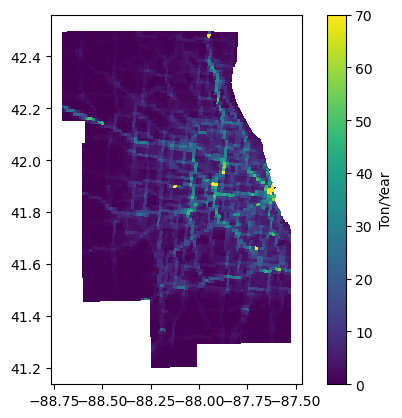

In [62]:
# Visualize and check data 
cmap.plot('NOX', vmin=0, vmax=70,legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap['NOX'].max()

Text(0.5, 1.0, 'NEMO Annual Average NO$_x$')

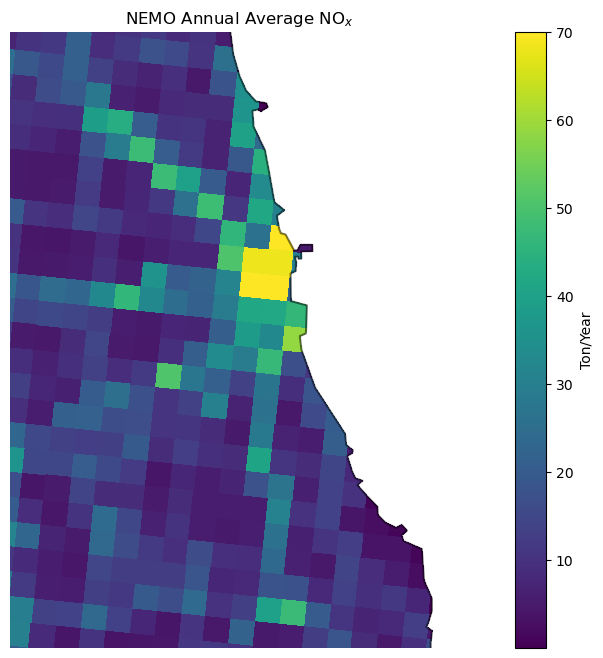

In [60]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap.plot('NOX',ax=ax, vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
ax.set_xlim(-87.8, -87.5,)
ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('NEMO Annual Average NO$_x$')

In [65]:
## NU CCRG
ladco_nox_1_33km = xr.DataArray(ladco_nox_1_33km,
                      coords= {'lat':ladco_nox_1_33km['lat'] , 'lon':ladco_nox_1_33km['lon']},
                      dims=['y','x'])

datas = [np.array(ladco_nox_1_33km).ravel(),np.array(ladco_pm25_1_33km).ravel(),np.array(ladco_pm10_1_33km).ravel()]
datas_headers = ['NOX','PM25','PM10']

In [66]:
###
d = {}
for i in range(len(datas)):
    d[datas_headers[i]]=datas[i]

# pull locations and put into shapely point so we can do geographical transformations
pointline = [Point(lon.ravel()[i],lat.ravel()[i]) for i in range(len(lon.ravel()))]
# add in geometry into dictionary
d['geometry']=pointline

# make geodataframe using dictionary and transform lon/lats projections into the same geometry as the tracts
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
#gdf = gdf.to_crs(tract_shapes.crs)
# pull out these lat lon points that have the tract crs
x,y = gdf['geometry'].x,gdf['geometry'].y

In [67]:
# Start to make little polygons to surround the centroids
# Create outer limits
#       L
#       lu----ru
# H     |   c  |
#       |      |
#       ll----rl
#
# set up empty shape to hold the future polygons
shape=np.zeros(lon.shape).tolist()
# go through the indices in the lat lon
for i in range(len(lon)):
        for j in range(len(lon[0])):
            X0,Y0 = lat[i][j],lon[i][j]
            # get corners
            lo_lu, la_lu = latd[i][j],lond[i][j]
            lo_ru, la_ru = latd[i+1][j],lond[i+1][j]
            lo_rl, la_rl = latd[i+1][j+1],lond[i+1][j+1]
            lo_ll, la_ll = latd[i][j+1],lond[i][j+1]
            # create points of corners
            pointList = [Point(lo_lu, la_lu),Point(lo_ru, la_ru), Point(lo_rl, la_rl), Point(lo_ll, la_ll),Point(lo_lu, la_lu)]
            # create a polygon from the corners
            poly = Polygon([[p.y, p.x] for p in pointList])
            # put the shape of the pixel into the shape list
            shape[i][j] = poly 

In [68]:
# put list of shapes into final gdf, needs to be 1D
shape = np.array(shape).ravel()
d['geometry'] = shape
d['lat'],d['lon'] = lat.ravel(),lon.ravel()
d['lat_m'],d['lon_m'] = x,y
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
gdf.to_file('ladco_1_33km_cons_annual.shp')

241.0995635986328

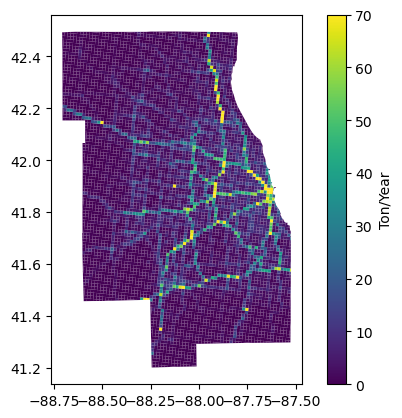

In [69]:
cmap = gpd.clip(gdf, cmap_cty.to_crs('EPSG:4326'))
cmap.plot('NOX', vmin=0, vmax=70,legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"})#,antialiased=False)
cmap['NOX'].max()

In [71]:
### UVM
rowan_nox_1_33km = xr.DataArray(rowan_nox_1_33km,
                      coords= {'lat':rowan_nox_1_33km['lat'] , 'lon':rowan_nox_1_33km['lon']},
                      dims=['y','x'])

datas = [np.array(rowan_nox_1_33km).ravel(),np.array(rowan_pm25_1_33km).ravel(),np.array(rowan_pm10_1_33km).ravel()]
datas_headers = ['NOX','PM25','PM10']

In [72]:
###
d = {}
for i in range(len(datas)):
    d[datas_headers[i]]=datas[i]

# pull locations and put into shapely point so we can do geographical transformations
pointline = [Point(lon.ravel()[i],lat.ravel()[i]) for i in range(len(lon.ravel()))]
# add in geometry into dictionary
d['geometry']=pointline

# make geodataframe using dictionary and transform lon/lats projections into the same geometry as the tracts
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
#gdf = gdf.to_crs(tract_shapes.crs)
# pull out these lat lon points that have the tract crs
x,y = gdf['geometry'].x,gdf['geometry'].y

# Start to make little polygons to surround the centroids
# Create outer limits
#       L
#       lu----ru
# H     |   c  |
#       |      |
#       ll----rl
#
# set up empty shape to hold the future polygons
shape=np.zeros(lon.shape).tolist()
# go through the indices in the lat lon
for i in range(len(lon)):
        for j in range(len(lon[0])):
            X0,Y0 = lat[i][j],lon[i][j]
            # get corners
            lo_lu, la_lu = latd[i][j],lond[i][j]
            lo_ru, la_ru = latd[i+1][j],lond[i+1][j]
            lo_rl, la_rl = latd[i+1][j+1],lond[i+1][j+1]
            lo_ll, la_ll = latd[i][j+1],lond[i][j+1]
            # create points of corners
            pointList = [Point(lo_lu, la_lu),Point(lo_ru, la_ru), Point(lo_rl, la_rl), Point(lo_ll, la_ll),Point(lo_lu, la_lu)]
            # create a polygon from the corners
            poly = Polygon([[p.y, p.x] for p in pointList])
            # put the shape of the pixel into the shape list
            shape[i][j] = poly 

In [73]:
# put list of shapes into final gdf, needs to be 1D
shape = np.array(shape).ravel()
d['geometry'] = shape
d['lat'],d['lon'] = lat.ravel(),lon.ravel()
d['lat_m'],d['lon_m'] = x,y
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
gdf.to_file('uvm_1_33km_cons_annual.shp')

<Axes: >

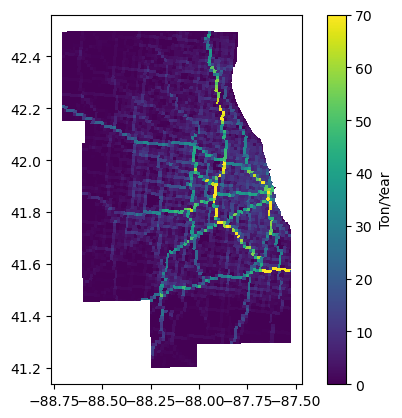

In [74]:
cmap = gpd.clip(gdf, cmap_cty.to_crs('EPSG:4326'))
cmap.plot('NOX', vmin=0, vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"},antialiased=False)